# **NLP Disaster Tweets Kaggle Mini-Project**

In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
import re
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation, digits, printable
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
color = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### **Brief description of the problem and data**

This project is about Natural Language Processing with Disaster Tweets which is one of the competition on Kaggle, the data using in this project is a dataset of tweets from Twitter.

Twitter is an important social media, and there are many people tweet everywhere and everytime, but it is not easy for machine to understand what the tweets are really about. The challenge of this project is to build a model to predicts tweets which are about real disasters or not.

### **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP Disaster Tweets Kaggle Mini-Project/train.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


First, we take a look at the training data, we can see that there are some missing data in the keyword and location columns. About 0.8% of keyword data is missing and 33% of location data is missing.

In [6]:
#Filtering missing data to have a quick look at the data
train_df[(pd.isnull(train_df['keyword']) == False) & 
         (pd.isnull(train_df['location']) == False)].head(10)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,0


We can see that location can be a country, a city or somewhere is not really existed like "milky way" or "World Wide". And the text is even more messy, urls are involved in the text. It looks like that keyword is about the disaster mentioned in the text.

In [7]:
train_df['keyword'].nunique()

221

In [8]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

There are 221 unique keywords, but some of them should be the same keyword, like "hijack", "hijacker" and "hijacking"

In [9]:
train_df['location'].nunique()

3341

It seems that location should not be using in the model, because 33% of the data is missing and the values are not organized since we can see that there are 3,341 unique values in location.

#### Text Word Count

In [10]:
#Counting number of words by groups
disaster_word_count = train_df[train_df['target'] == 1]['text'].str.split(' ').str.len()
non_disaster_word_count = train_df[train_df['target'] == 0]['text'].str.split(' ').str.len()

Text(0.5, 1.0, 'Non Disaster Word Count')

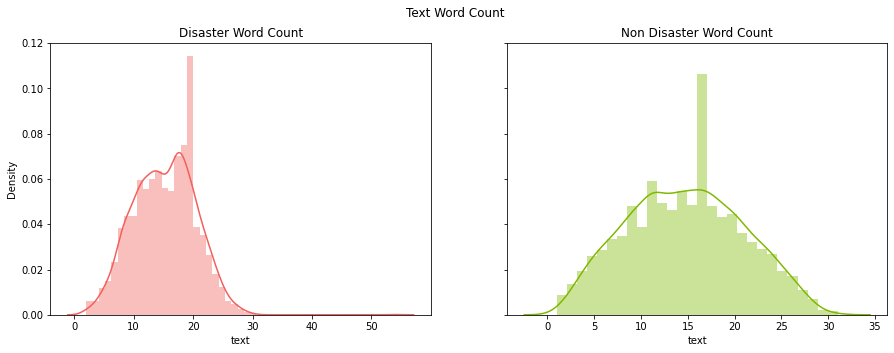

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Text Word Count')

# Disaster Word Count
sns.distplot(disaster_word_count, ax = axes[0], color = color[4])
axes[0].set_title('Disaster Word Count')

# Non Disaster Word Count
sns.distplot(non_disaster_word_count, ax = axes[1], color = color[2])
axes[1].set_title('Non Disaster Word Count')

In [12]:
print('The average number of word count of disaster tweets:', round(disaster_word_count.mean()))
print('The average number of word count of non disaster tweets:', round(non_disaster_word_count.mean()))

The average number of word count of disaster tweets: 15
The average number of word count of non disaster tweets: 15


It seems that the average numbers of word count of disaster tweets and non disaster tweets are the same, but the distributions are a little bit different, the distribution of disaster word count seems to be leptokurtic, and the distribution of non disaster word count seems to be platykurtic.

#### Target Distribution

In [13]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Around 57% of the data is not disaster, and 43% of the data is real disaster.

#### Data Cleaning

In [14]:
train_df['clean_text'] = train_df['text'].str.lower() #Transforming all the letters into lower letters
stop_words = list(stopwords.words('english')) #Using for removing stop words
punctuation = list(punctuation) #Using for removing punctuation
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in train_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_temp = re.sub(r'http\S+', '', clean_temp) #Using regular expression to remove url
    clean_text_list.append(clean_temp)
train_df['clean_text'] = pd.Series(clean_text_list)

In [15]:
train_df['clean_text'] = train_df['text'].str.lower() #Transforming all the letters into lower letters
stop_words = list(stopwords.words('english')) #Using for removing stop words
punctuation = list(punctuation) #Using for removing punctuation
printable = list(printable) #Using for removing non printable characters
digits = list(digits) #Using for removing digits
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in train_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_temp = re.sub(r'http\S+', '', clean_temp) #Using regular expression to remove url
    clean_temp = re.sub(r'@\S+', 'mention_user', clean_temp) #Using regular expression to replace mention
    clean_punctuation_non_printable_digits = [char for char in clean_temp if char not in punctuation and char in printable and char not in digits]
    clean_temp = ''.join(clean_punctuation_non_printable_digits)
    clean_text_list.append(clean_temp)
train_df['clean_text'] = pd.Series(clean_text_list)

Cleaning the text by transforming all the letters into lower letters, removing stop words, punctuation and urls.

In [16]:
tokenizer = Tokenizer(num_words = 3000, split=' ') #Assume there are 3,000 frequent words
tokenizer.fit_on_texts(train_df['clean_text'].values)
X_train = tokenizer.texts_to_sequences(train_df['clean_text'].values)
X_train = pad_sequences(X_train, maxlen = 50)
y_train = train_df['target']

Using Tokenizer to tokenizer the text and spliting the data for training the model

### **Model Architecture**

Now, we are going to build the model. My way to doing this is assuming there are around 3,000 frequent words and turning each word into a 64-length vector, so I first added an embedding layer to deal with the text. Then, I added two LSTM(Long Short-Term Memory) layers with 100 units. Finally, I added and dropout layer to prevent overfitting and a dense layer with sigmoid activation function which gives 0 or 1 predictions.

Finally, since this is a binary classification problem, I chose 'binary_crossentropy' as the loss function, and using learning rate of 0.001 and 0.0005 got similar results.

In [17]:
model = Sequential([
    layers.Embedding(3000, 64, input_length = 50),
    layers.Dropout(0.2),
    layers.LSTM(100, dropout = 0.2, return_sequences = True, recurrent_dropout = 0.4),
    layers.Dropout(0.2),
    layers.LSTM(100, dropout = 0.2, recurrent_dropout = 0.4),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = keras.optimizers.Adam(0.0005),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            192000    
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 100)           66000     
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [19]:
callback = EarlyStopping(monitor='val_loss', patience = 3)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.001)
history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, callbacks = [callback, reduce_lr])

Epoch 1/10
191/191 [==============================] - 49s 223ms/step - loss: 0.6082 - accuracy: 0.6639 - val_loss: 0.4792 - val_accuracy: 0.7814 - lr: 5.0000e-04
Epoch 2/10
191/191 [==============================] - 42s 220ms/step - loss: 0.4077 - accuracy: 0.8253 - val_loss: 0.4601 - val_accuracy: 0.7820 - lr: 5.0000e-04
Epoch 3/10
191/191 [==============================] - 42s 222ms/step - loss: 0.3461 - accuracy: 0.8565 - val_loss: 0.5092 - val_accuracy: 0.7485 - lr: 5.0000e-04
Epoch 4/10
191/191 [==============================] - 42s 221ms/step - loss: 0.3096 - accuracy: 0.8709 - val_loss: 0.5090 - val_accuracy: 0.7571 - lr: 5.0000e-04
Epoch 5/10
191/191 [==============================] - 42s 220ms/step - loss: 0.2901 - accuracy: 0.8796 - val_loss: 0.5606 - val_accuracy: 0.7564 - lr: 5.0000e-04


### **Results and Analysis**

In [20]:
history.history

{'loss': [0.6081822514533997,
  0.40772852301597595,
  0.3460792899131775,
  0.30957478284835815,
  0.2900572419166565],
 'accuracy': [0.6638752222061157,
  0.8252873420715332,
  0.8564860224723816,
  0.8709359765052795,
  0.8796387314796448],
 'val_loss': [0.4791862368583679,
  0.46013540029525757,
  0.5092448592185974,
  0.5090453028678894,
  0.5605551600456238],
 'val_accuracy': [0.7813525795936584,
  0.7820091843605042,
  0.7485226392745972,
  0.7570584416389465,
  0.7564018368721008],
 'lr': [0.0005, 0.0005, 0.0005, 0.0005, 0.0005]}

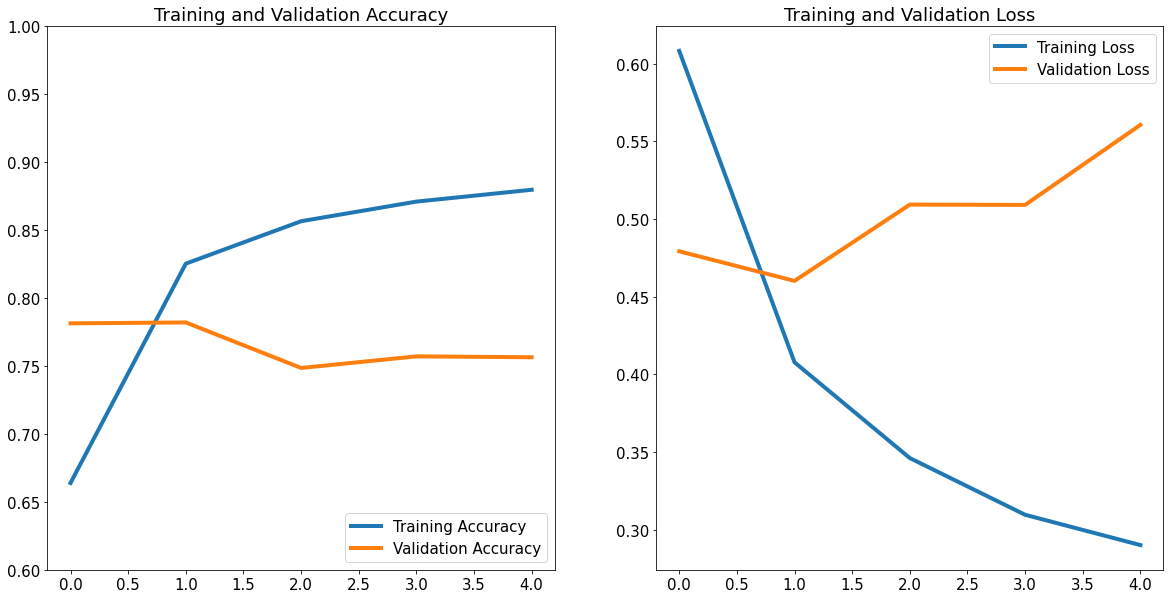

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.rc('font', size = 15)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 4)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 4)
plt.ylim(ymin = 0.6, ymax = 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth = 4)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 4)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We trainned the model with 10 epochs and setting a callback which would be triggered when validation loss is increasing in more than 3 epoches, and the trainning finally stopped at epoch 5. We can see that training accuracy keeps going up, but validation accuracy keeps stable at around 0.75.

In [22]:
y_pred = model.predict(X_train).round()
cf_matrix = confusion_matrix(y_train, y_pred)

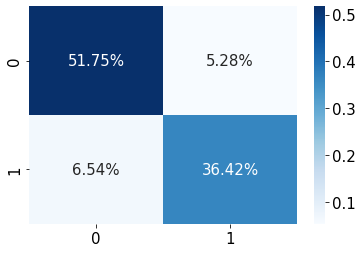

In [23]:
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

Around 5.28% of the data is classified as false positive, and 6.54% of the data is classified as false negative. This result shows that the model is really needed to improve in order to use it in real life. I think this false negative rate will be much higher in dealing with new data and we cannot accept in real life, since the model may give us the wrong signal to omit real disasters.

In [48]:
#Starting to predicting the test dataset and making the submission
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP Disaster Tweets Kaggle Mini-Project/test.csv')
test_df['clean_text'] = test_df['text'].str.lower() #Transforming all the letters into lower letters
stop_words = list(stopwords.words('english')) #Using for removing stop words
punctuation = list(punctuation) #Using for removing punctuation
printable = list(printable) #Using for removing non printable characters
digits = list(digits) #Using for removing digits
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in test_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words]
    clean_temp = ' '.join(clean_temp)
    clean_temp = re.sub(r'http\S+', '', clean_temp) #Using regular expression to remove url
    clean_temp = re.sub(r'@\S+', 'mention_user', clean_temp) #Using regular expression to replace mention
    clean_punctuation_non_printable_digits = [char for char in clean_temp if char not in punctuation and char in printable and char not in digits]
    clean_temp = ''.join(clean_punctuation_non_printable_digits)
    clean_text_list.append(clean_temp)
test_df['clean_text'] = pd.Series(clean_text_list)

In [49]:
tokenizer = Tokenizer(num_words = 3000, split=' ') #Assume there are 3,000 frequent words
tokenizer.fit_on_texts(test_df['clean_text'].values)
X_submission = tokenizer.texts_to_sequences(test_df['clean_text'].values)
X_submission = pad_sequences(X_submission, maxlen = 50)

In [50]:
y_pred_submission = model.predict(X_submission)

In [58]:
submission_df = pd.DataFrame(test_df['id'], columns =['id'])
submission_df['target'] = np.round(y_pred_submission).astype(int).reshape(3263)

In [59]:
submission_df.to_csv('submission.csv', index = False)

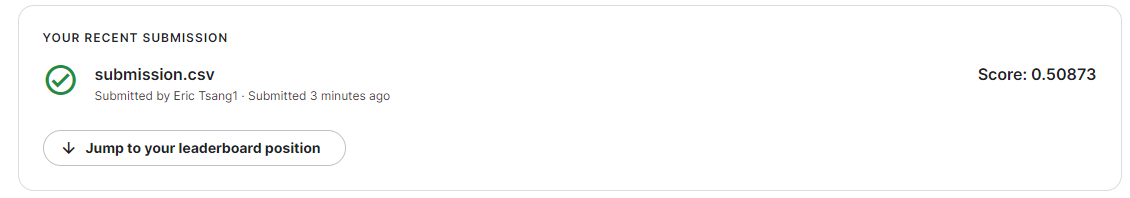

The test result is not good, which only has a score of 0.50873

### **Conclusion**

Training a LSTM model is not a easy job, it is actually quite tough. There are many ways to fine tune the model, we can keep changing the architecture of the model to see if it can get a better result, but it is really time consuming.

I think the model created in this project may be suffered from overfitting problem, so the model get an acceptable result in training but a poor result in the submission. We can spend more time to clean the text in order to reduce the noise, so that the model can be generalized better, and fine tuning the dropout parameter to achieve better regularization to the network.

Overall, it is quite amazing that technology can let amateur people like me to train a model to predit disaster from tweets, data science is really bringing a greate future for human civilization.